# Fitting a Supercrystal Structurefactor Model
In the following example, we analyze SAXS diffractorgrams of nanoparticle supercrystal in order to determine the lattice constant and structure of the superlattice via a structurfactor model.

In [1]:
import numpy as np
# collect suspension files
import glob
files=glob.glob('data\\superstructures\\*chi')
files[:5]

['data\\superstructures\\sample1-00001.chi',
 'data\\superstructures\\sample1-00002.chi',
 'data\\superstructures\\sample1-00003.chi',
 'data\\superstructures\\sample1-00004.chi',
 'data\\superstructures\\sample1-00005.chi']

In [2]:
import sys
sys.path.append('./..') # this is required to recognize the nanoscatterfit package which is located in the parent directory
from nanoscatterfit import  import_rawdata
#import the diffractogram into a dataframe either using predefined function or pandas
df=import_rawdata(files[60])
df.head()

,q,I
0,0.012804,259.26761
1,0.038412,263.99283
2,0.064020,271.95160
3,0.089628,287.08679
4,0.115236,303.18973


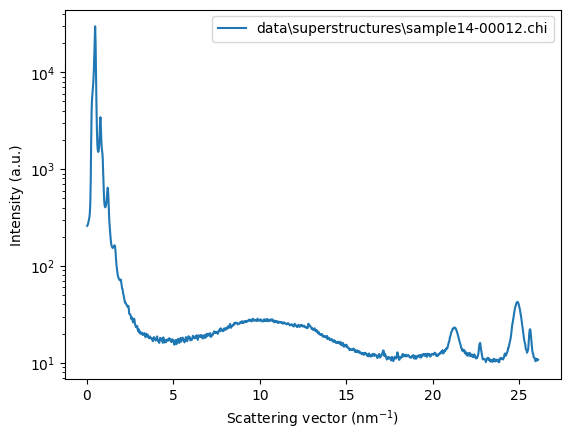

In [3]:
#plot the data
from nanoscatterfit import plot
plot(df, x='q',y='I', label=files[60])

## Calculate the Structure Factor
- get the structure factor by dividing the intensity through the form factor, considering I = S * F
- the formfactor related to the particles in the superlattice corresponds to the measured diffraction pattern of the nanoparticle suspension 

In [4]:


# cut off irrelevant q values
from nanoscatterfit import cut_diffractogram
df=cut_diffractogram(df, 0,2.5)
df_suspension= import_rawdata(r'.\data\suspensions\suspension1.chi')


from nanoscatterfit import calc_structurefactor
#calculate the structure factor and adds it as new columns to the dataframe
df= calc_structurefactor(df, df_suspension,normalize=True)
df.head()

,q,I,F,S
0,0.038412,263.99283,445.14215,0.082299
1,0.064020,271.95160,447.13855,0.084401
2,0.089628,287.08679,457.45987,0.087088
3,0.115236,303.18973,490.04810,0.085857
4,0.140844,317.48169,534.80737,0.082380


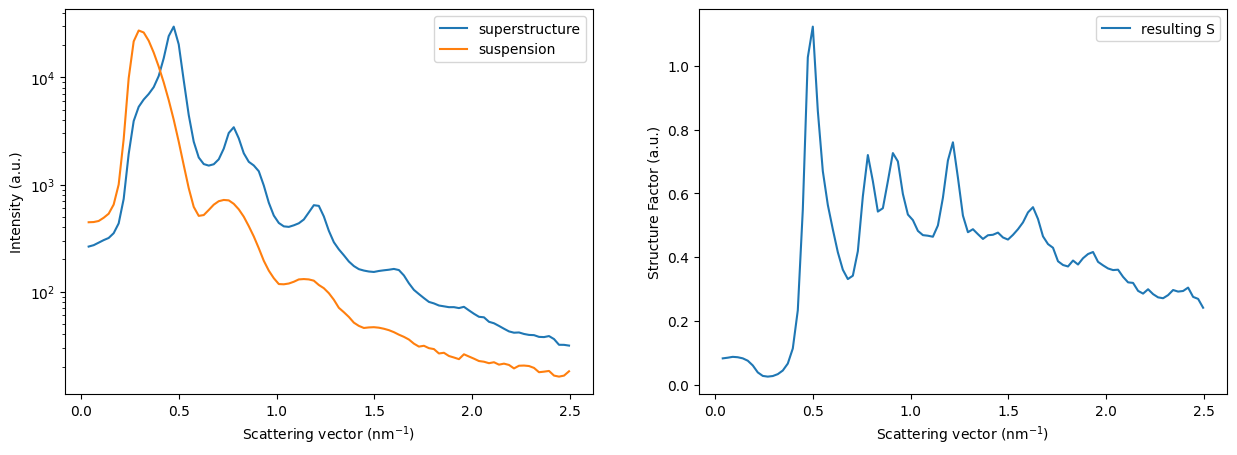

In [5]:
# plotting the obtained structure factor
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1,2,figsize=(15,5))
plot(df,y='I', ax=axes[0], label='superstructure')
plot(df,y='F', ax=axes[0], label='suspension')

plot(df,y='S', ax=axes[1], label='resulting S',scale='linear')

## Deconvoluting the Diffraction Pattern
- first the baseline is fit to the diffraction pattern
- the structure (e.g. FCC) can be estimated from the peak positions using the function indcate_diffractionpattern(). It also helps to estimate the value of the (111) peak position
- the diffraction pattern is deconvoluted using the fit_structurefactor() function
    - here one either provide an estimate of q111 as an argument or using 'auto' to use the first large peak as rough (111) position
    - the q range of the input x,y datapair shoould be adjusted for optimal fit by providing a tuple as an argument e.g. q_range=(0.25,1.5). Otherwise the arguement q_range='auto' estimates the q range automatically by using the first and last tale in the diffractorgram.

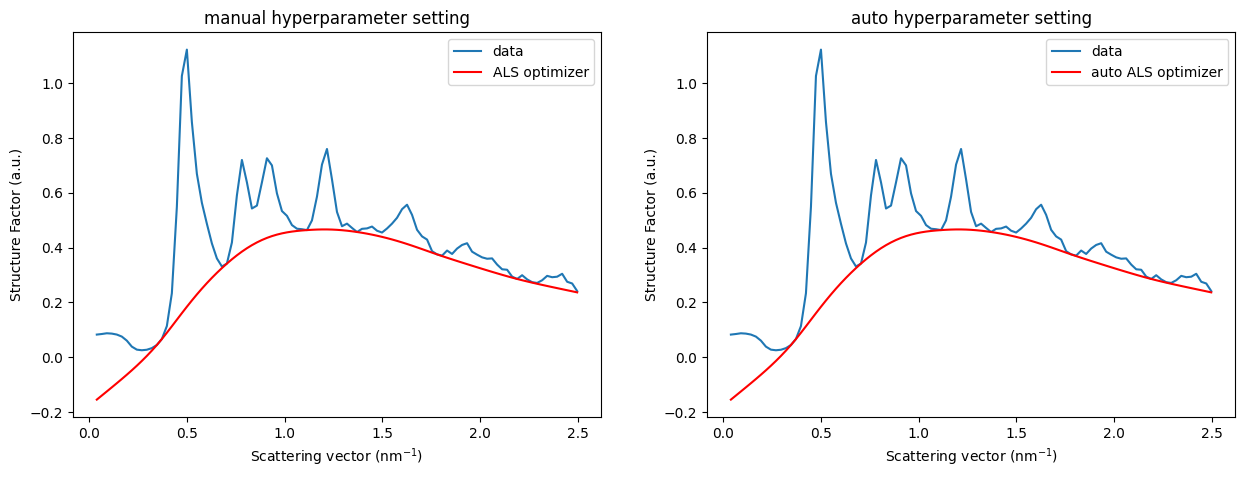

In [6]:
# before deconvoluting the diffraction pattern, we need to subtract the baseline
# e.g. using the ALS optimizer
from nanoscatterfit import baseline_als_optimized
baseline=baseline_als_optimized(df.S,lam=1E-6,p=1E-10)



fig, axes = plt.subplots(1,2,figsize=(15,5))
plot(df,y='S', ax=axes[0], label='data',scale='linear')
axes[0].plot(df.q, baseline,color='red',label='ALS optimizer')
axes[0].legend()
axes[0].set_title('manual hyperparameter setting')
 

# alternatively for batch processing the optimal hyperparameters lam and p can be determined using the auto baseline optimizer
from nanoscatterfit import auto_baseline_optimizer

baseline= auto_baseline_optimizer(df.S,lam=(-5,-2),p=(-11,-5)) # the ranges of lam an p exponents need to be specified
plot(df,y='S', ax=axes[1], label='data',scale='linear')
axes[1].plot(df.q, baseline,color='red',label='auto ALS optimizer')
axes[1].legend()
axes[1].set_title('auto hyperparameter setting')
# add baseline to df for easier handling
df['baseline']=baseline

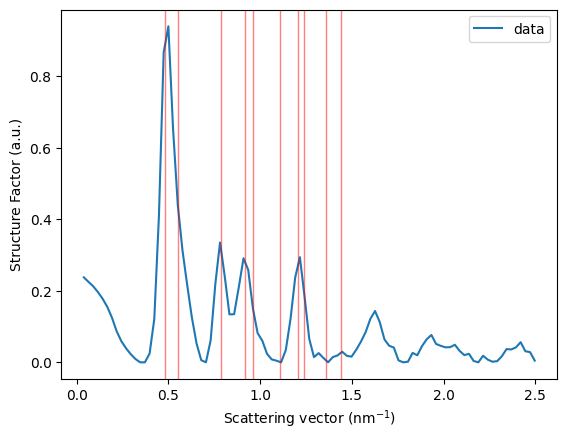

In [7]:
fig, ax = plt.subplots()

plot(df,y='S',subtractbaseline=True, ax=ax, label='data',scale='linear')
from nanoscatterfit import indcate_diffractionpattern
peaks=indcate_diffractionpattern(q111=0.48,structure='fcc', ax=ax)

In [8]:
# fit the model to the data
from nanoscatterfit import fit_structurefactor, get_structureinfo

out=fit_structurefactor(df.q,(df.S - baseline),'fcc',max_sigma_diff=0.05,q_range='auto', q111='auto')
print(f'fit carried out with R² = {out.rsquared:.2f}')

a, Dsize= get_structureinfo(out,structure='fcc')
print(f'determined lattice constant is a = {a:.2f} nm')
print(f'determined domain size is Dsize = {Dsize:.0f} nm')


fit carried out with R² = 0.95
determined lattice constant is a = 22.58 nm
determined domain size is Dsize = 92 nm


(0.25, 1.5)

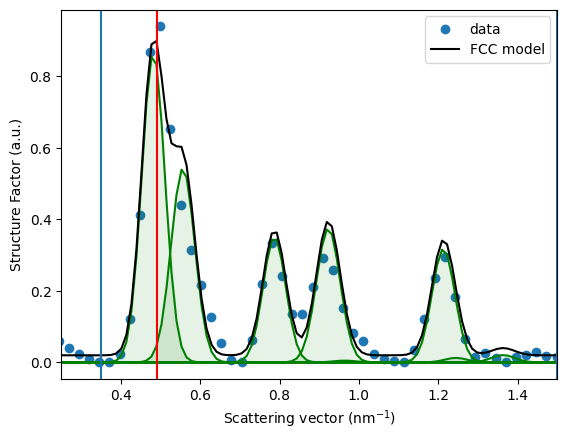

In [9]:
# plotting the fit results
fig, ax =plt.subplots()
plot(df,y='S',subtractbaseline=True,ax=ax,scale='linear',line=False, label='data')
from nanoscatterfit import plot_structuremodel
xarray=np.linspace(0.25,1.5,100)
gaussians=plot_structuremodel(xarray,out, ax=ax, label='FCC model')

# the analysis.log file states that autocut was perfomed in the following intervall:
ax.axvline(0.35)
ax.axvline(1.5)
# the analysis.log file states that automatic detection of the (111) peak was at the following position:
ax.axvline(0.49,color='red')
ax.set_xlim(0.25,1.5)

In [10]:
# printing out the fitting results
out

## Batch Processing the Analysis
- information about the corresponding particle batch must be provided, e.g. via an additional excel file, for automatically assigning the particles' form factor (i.e. the corresponding suspension diffractogram)

In [11]:
# load the particle batch information 
import pandas as pd
batchinfo=pd.read_excel('data/sampleinfos.xlsx',index_col=0)
batchinfo=batchinfo.to_dict('index')
batchinfo

{1: {'Particle_Batch': 'suspension3'},
 2: {'Particle_Batch': 'suspension3'},
 3: {'Particle_Batch': 'suspension4'},
 4: {'Particle_Batch': 'suspension1'},
 5: {'Particle_Batch': 'suspension1'},
 6: {'Particle_Batch': 'suspension1'},
 7: {'Particle_Batch': 'suspension1'},
 8: {'Particle_Batch': 'suspension4'},
 9: {'Particle_Batch': 'suspension4'},
 10: {'Particle_Batch': 'suspension4'},
 11: {'Particle_Batch': 'suspension4'},
 12: {'Particle_Batch': 'suspension1'},
 13: {'Particle_Batch': 'suspension1'},
 14: {'Particle_Batch': 'suspension1'}}

In [12]:
# test for correct assignment of particle batch via the samples' file name

def assign_suspension(f):
    fname=f.split('\\')[-1]
    samplenumber=int(fname.split('-')[0].replace('sample',''))
    suspension=batchinfo.get(samplenumber)['Particle_Batch']
    return suspension
for f in files:
    suspension=assign_suspension(f)
    # print every 10th file name
    if '00001.chi' in f:
        # print in a table structure
        print(f'{f} --> corresponding suspension is {suspension}')

data\superstructures\sample1-00001.chi --> corresponding suspension is suspension3
data\superstructures\sample10-00001.chi --> corresponding suspension is suspension4
data\superstructures\sample11-00001.chi --> corresponding suspension is suspension4
data\superstructures\sample12-00001.chi --> corresponding suspension is suspension1
data\superstructures\sample13-00001.chi --> corresponding suspension is suspension1
data\superstructures\sample14-00001.chi --> corresponding suspension is suspension1
data\superstructures\sample2-00001.chi --> corresponding suspension is suspension3
data\superstructures\sample3-00001.chi --> corresponding suspension is suspension4
data\superstructures\sample4-00001.chi --> corresponding suspension is suspension1
data\superstructures\sample5-00001.chi --> corresponding suspension is suspension1
data\superstructures\sample6-00001.chi --> corresponding suspension is suspension1
data\superstructures\sample7-00001.chi --> corresponding suspension is suspension1

In [13]:
# make sure to have the suspension files callable via a dictionary as follows:
suspensionfiles=glob.glob('data\\suspensions\\*chi')
suspensions={}

for f in suspensionfiles:
    fname=f.split('\\')[-1].replace('.chi','')
    df_suspension=import_rawdata(f)
    suspensions[fname]=df_suspension
# test if the correct suspension dataframe can be called by the filepath of the sample
print(f'for file: {files[0]}')
print(f'the corresponding particle susspension is: {assign_suspension(files[0])}')
suspensions.get(assign_suspension(files[0]))

for file: data\superstructures\sample1-00001.chi
the corresponding particle susspension is: suspension3


,q,I
0,0.012944,1585.047700
1,0.038831,1579.503400
2,0.064719,1649.053800
3,0.090606,1785.984700
4,0.116494,2105.246100
...,...,...
1582,40.966980,1.000366
1583,40.992867,9.890395
1584,41.018753,0.917058
1585,41.044640,1.355877


after setting up the assignment of suspensions via dictionaries and functions batch processsing can be done as follows:

In [14]:
%load_ext autoreload
%autoreload 2
from nanoscatterfit.nanoscatterfit import auto_baseline_optimizer,fit_structurefactor, isscatter
def pipeline(f:str):
    df=import_rawdata(f)
    # start with the preprocessing
    df=cut_diffractogram(df,0,2.0)
    # here comes the automated assignment of the corresponding suspension dataframe we create above via the sample name
    df_suspension=suspensions.get(assign_suspension(f))
    df= calc_structurefactor(df, df_suspension,normalize=True)
    baseline= auto_baseline_optimizer(df.S,lam=(-5,-2),p=(-11,-5),alpha=1,beta=14)
    # baseline=baseline_als_optimized(df.S, lam=1E-3, p=1E-7, niter=50)
    df['baseline']=baseline

    # not all files correspond to actual diffraction patterns, as sometimes the sample was missed by the beam. hence the following optional filtering function can be added:
    if isscatter(df):
        # here comes the actual deconvolution part
        out=fit_structurefactor(df.q,(df.S - baseline),'fcc',max_sigma_diff=0.05,q_range='auto', q111='auto')
        return df,out
    else: return df,None


fit carried out with R² = 0.94


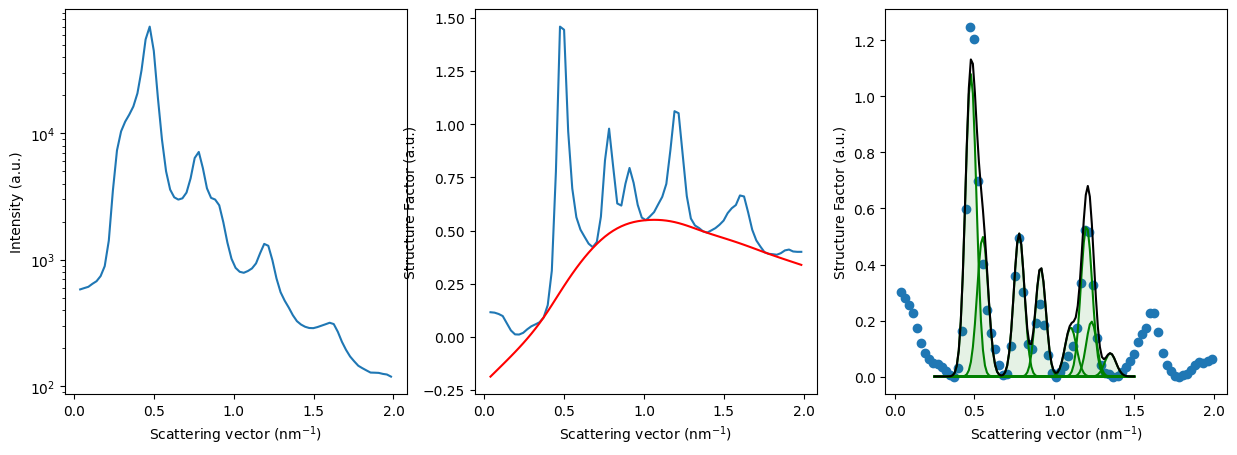

In [15]:
# check if the pipeline works correctly

samplenumber = 2
scannumber= 5

f= list(filter(lambda x: 'sample'+str(samplenumber)+'-' in x, files))[scannumber]
df, out = pipeline(f)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
ax=axes[0]
plot(df,y='I',ax=ax,)
ax=axes[1]
plot(df,y='S',ax=ax,scale='linear')
ax=axes[2]
plot(df,y='S',subtractbaseline=True,line=False,ax=ax,scale='linear')
gaussians= plot_structuremodel(xarray,out, ax=ax)
print(f'fit carried out with R² = {out.rsquared:.2f}')

In [16]:
# running the pipeline and storing the results in a dictionary
results={}
for i,f in enumerate(files):
    print(f'running pipeline for sample {i+1} out of {len(files)}')
    df, out = pipeline(f)
    results[f]={'df':df,'out':out}
    if out is not None:
        print(f'fit carried out with R² = {out.rsquared:.2f}')

running pipeline for sample 1 out of 132
running pipeline for sample 2 out of 132
running pipeline for sample 3 out of 132
running pipeline for sample 4 out of 132
fit carried out with R² = 0.96
running pipeline for sample 5 out of 132
fit carried out with R² = 0.95
running pipeline for sample 6 out of 132
fit carried out with R² = 0.95
running pipeline for sample 7 out of 132
fit carried out with R² = 0.96
running pipeline for sample 8 out of 132
fit carried out with R² = 0.95
running pipeline for sample 9 out of 132
fit carried out with R² = 0.72
running pipeline for sample 10 out of 132
running pipeline for sample 11 out of 132
running pipeline for sample 12 out of 132
running pipeline for sample 13 out of 132
running pipeline for sample 14 out of 132
running pipeline for sample 15 out of 132
running pipeline for sample 16 out of 132
fit carried out with R² = 0.94
running pipeline for sample 17 out of 132
fit carried out with R² = 0.93
running pipeline for sample 18 out of 132
fit c

- below is an example on plotting the different diffractograms and their fits.
- in some cases the fit is very bad, e.g. see sample 2 scannumber 8, because the X-ray beam partially hit the samplee holder. 
- low quality data can be filtered out by checking the R² of the fit or by adding further check funcions similar to isscatter()

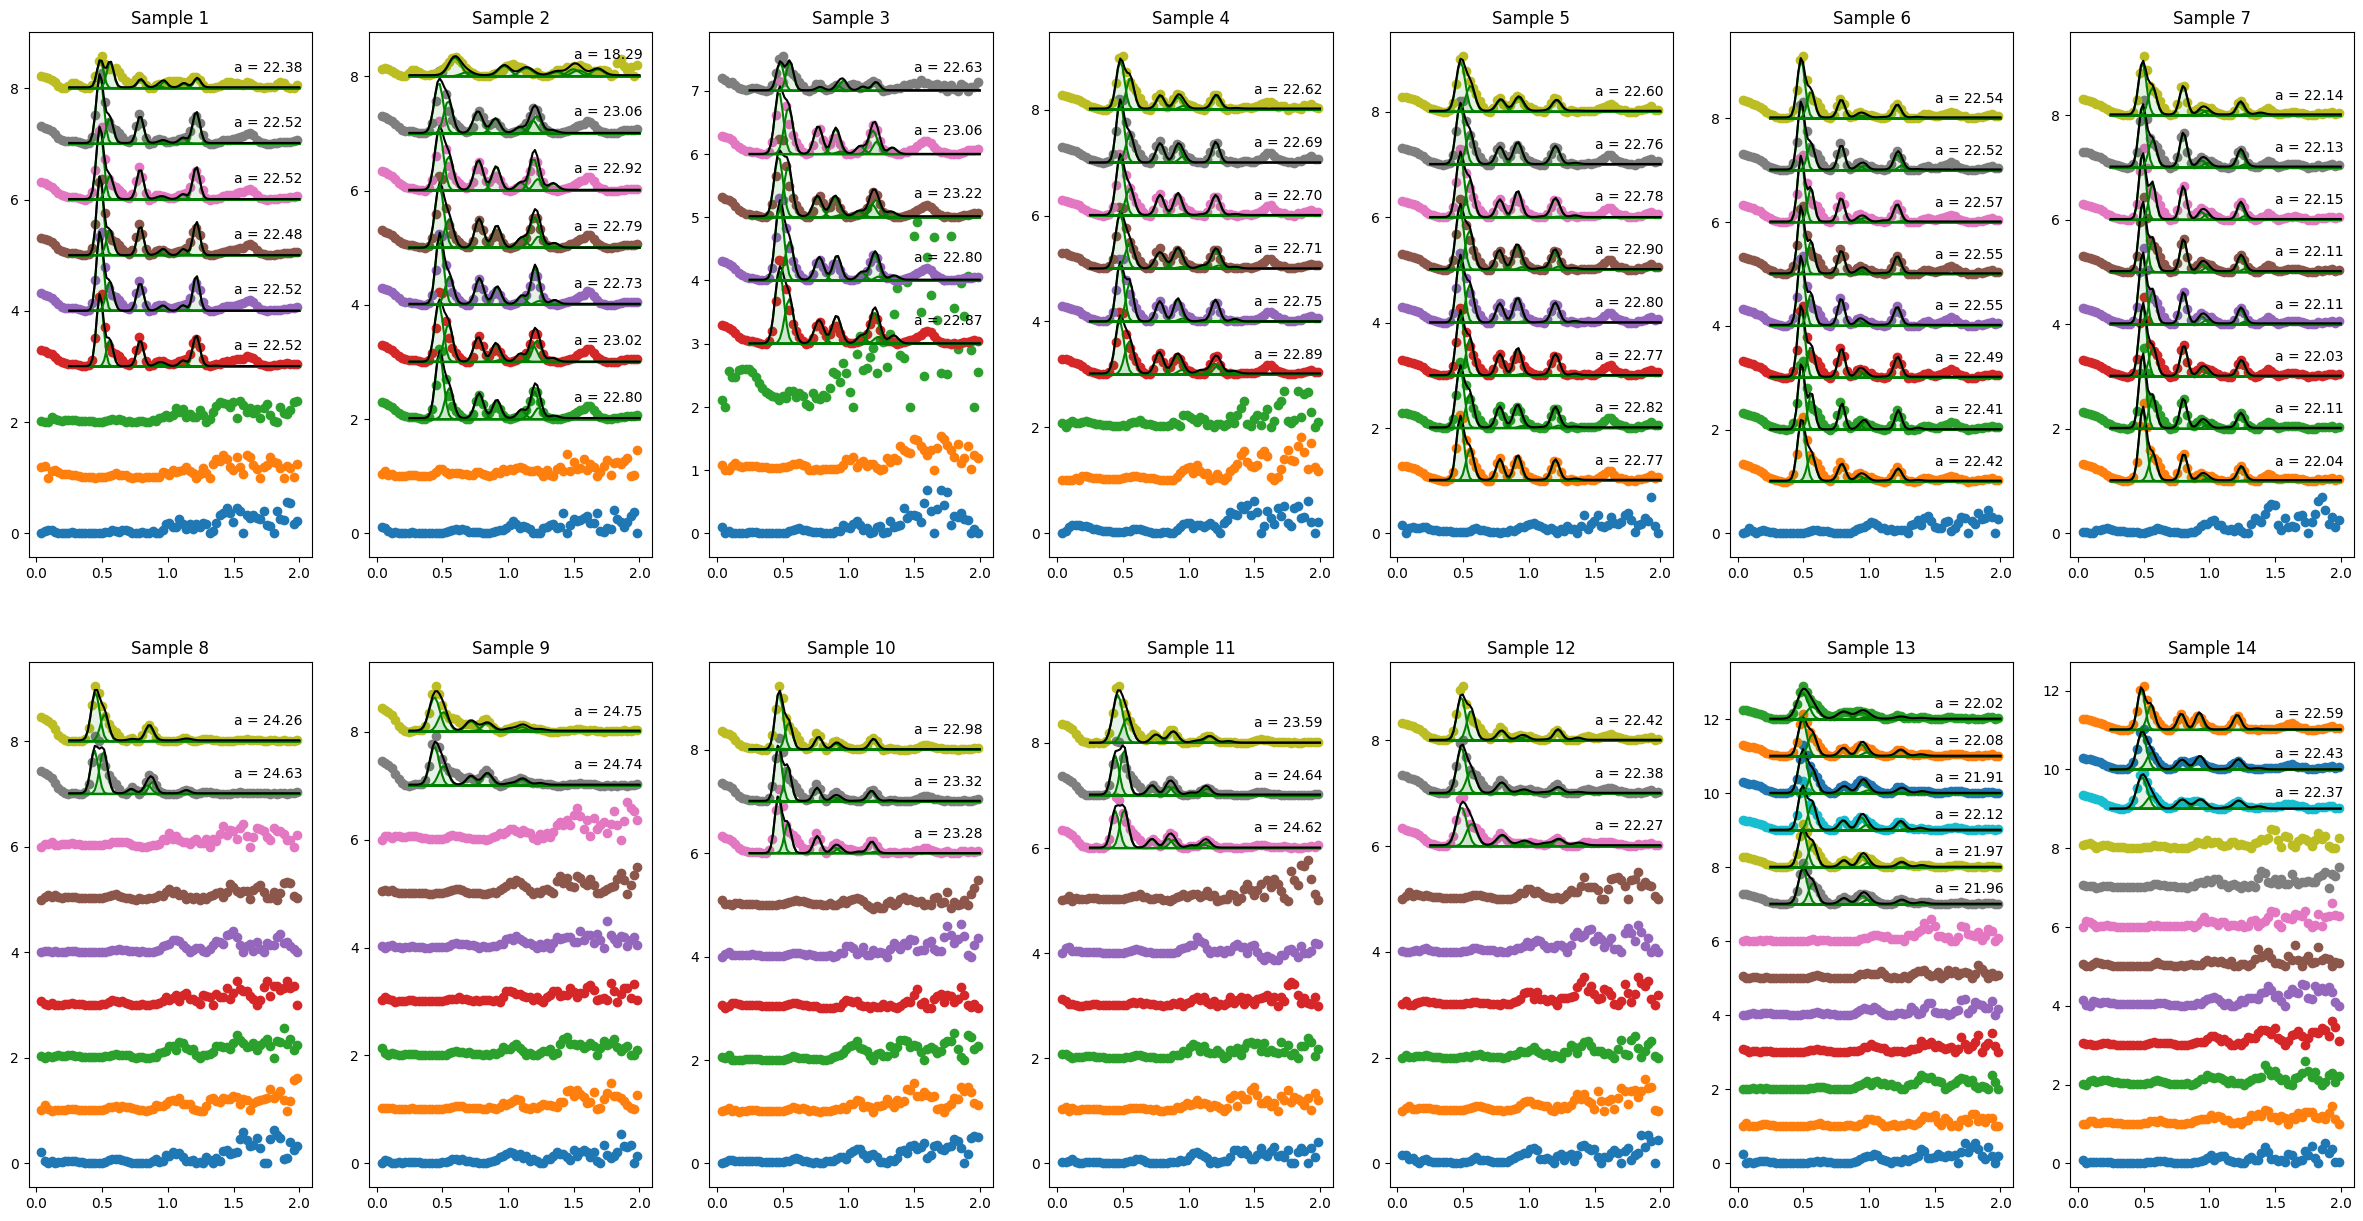

In [17]:

from nanoscatterfit.nanoscatterfit import plot_structuremodel

# plot some of the results:
fix, axes= plt.subplots(2,7, figsize=(30,15))
axes=axes.flatten()
i=0
samplenumber_=0
xarray=np.linspace(0.25,2,100)
for f,data in results.items():
    df,out=data['df'],data['out']
    fname=f.split('\\')[-1]
    samplenumber=int(fname.split('-')[0].replace('sample',''))
    if samplenumber_ != samplenumber: i=0
    ax= axes[samplenumber-1]
    ax.scatter(df.q,df.S-df.baseline + i)
    ax.set_title(f'Sample {samplenumber}')
    if out is not None:
        plot_structuremodel(xarray,out, ax=ax,yshift=i)
        # ax.text(1.5,i+0.5,f'R² = {out.rsquared:.2f}')
        a,Dsize = get_structureinfo(out, structure='fcc')
        ax.text(1.5,i+0.3,f'a = {a:.2f}')
    i+=1
    samplenumber_=samplenumber
fig.tight_layout()

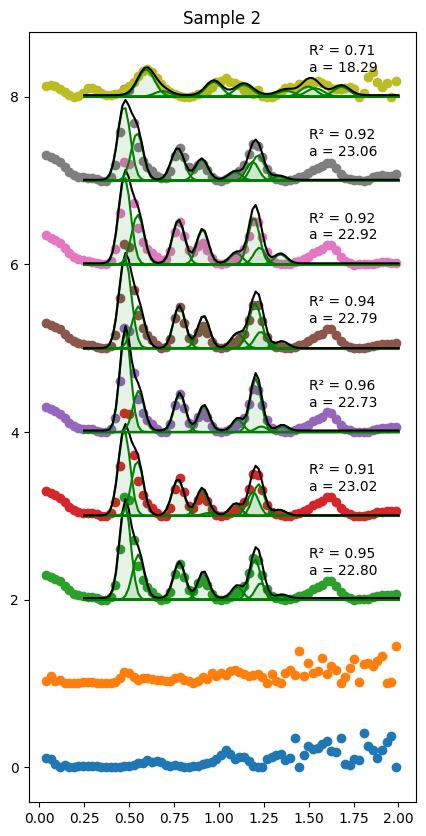

In [18]:
fig, ax = plt.subplots(figsize=(5, 10))

i=0

xarray=np.linspace(0.25,2,100)
for f,data in dict(filter(lambda x: 'sample2-' in x[0]  ,results.items())).items():
    df,out=data['df'],data['out']
    fname=f.split('\\')[-1]
    samplenumber=int(fname.split('-')[0].replace('sample',''))
    ax.scatter(df.q,df.S-df.baseline + i)
    ax.set_title(f'Sample {samplenumber}')
    
    if out is not None:
        a,Dsize = get_structureinfo(out, structure='fcc')
        plot_structuremodel(xarray,out, ax=ax,yshift=i)
        ax.text(1.5,i+0.5,f'R² = {out.rsquared:.2f}')
        ax.text(1.5,i+0.3,f'a = {a:.2f}')
    i+=1
